# Introduction to PyPSA

**Python for Power System Analysis (PyPSA)**

PyPSA is a python package that supports energy and electricity system modeling. The PyPSA package provides a framework for simulating and optimizing energy and electricity systems. PyPSA provides users structured components for which they can store the data which populates an optimization model.

## Learning Objectives

By the end of this session, you will:
1. Understand what PyPSA is and its core capabilities
2. Learn the basic components of a power system model in PyPSA
3. Build your first simple power system network
4. Run an economic dispatch model
5. Run a basic capacity expansion model
5. Visualize network topology and results

In [1]:
# Import necessary libraries
import pypsa
import os
import matplotlib.pyplot as plt
import logging

from helpers import (
    plot_generator_marginal_costs,
    plot_energy_balance,
    plot_capacity_comparison
)

logger = logging.getLogger("gurobipy")
logger.propagate = False

pypsa.__version__

'0.35.2'

## 1. Anatomy of a PyPSA Network

Lets start with an example network. This is a pypsa-usa network created for ERCOT with:
- demand data for the year 2030 from the NREL EFS
- 7 buses nodes
- 380 resource regions
- 72 transmission links

In [2]:
path = os.path.join("../data/examples", "elec_s380_c7a_ec_lv1.5_RPS-REM-TCT-1h_E.nc")
network = pypsa.Network(path)
network

INFO:pypsa.network.io:New version 1.0.0 available! (Current: 0.35.2)
INFO:pypsa.network.io:Imported network '' has buses, carriers, generators, global_constraints, links, loads, storage_units


PyPSA Network ''
----------------
Components:
 - Bus: 7
 - Carrier: 17
 - Generator: 1355
 - GlobalConstraint: 1
 - Link: 22
 - Load: 7
 - StorageUnit: 14
Snapshots: 8760

In [3]:
network.buses

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,...,country,reeds_zone,reeds_ba,interconnect,nerc_reg,trans_reg,trans_grp,reeds_state,rec_trading_zone,substation_lv
Bus,,,,,,,,,,,,,,,,,,,,,
p60,230.0,,-100.465149,33.045614,AC,,,1.0,0.0,inf,...,p60,p60,ERCO,texas,ERCOT,ERCOT,ERCOT,TX,ERCOT,True
p61,230.0,,-101.298453,30.883641,AC,,,1.0,0.0,inf,...,p61,p61,ERCO,texas,ERCOT,ERCOT,ERCOT,TX,ERCOT,True
p62,230.0,,-102.583086,31.840422,AC,,,1.0,0.0,inf,...,p62,p62,ERCO,texas,ERCOT,ERCOT,ERCOT,TX,ERCOT,True
p63,230.0,,-96.863645,32.436442,AC,,,1.0,0.0,inf,...,p63,p63,ERCO,texas,ERCOT,ERCOT,ERCOT,TX,ERCOT,True
p64,230.0,,-97.678235,30.141432,AC,,,1.0,0.0,inf,...,p64,p64,ERCO,texas,ERCOT,ERCOT,ERCOT,TX,ERCOT,True
p65,230.0,,-98.111416,28.023661,AC,,,1.0,0.0,inf,...,p65,p65,ERCO,texas,ERCOT,ERCOT,ERCOT,TX,ERCOT,True
p67,230.0,,-95.371812,29.737889,AC,,,1.0,0.0,inf,...,p67,p67,ERCO,texas,ERCOT,ERCOT,ERCOT,TX,ERCOT,True


In [4]:
network.consistency_check()

In [5]:
print(set(network.generators.carrier))
network.generators

{'nuclear', 'hydro', 'biomass', 'hydrogen_ct', 'CCGT-95CCS', 'solar', 'onwind', 'OCGT', 'oil', 'coal', 'CCGT'}


,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt,vom_cost,fuel_cost,heat_rate,carrier_base,land_region
Generator,,,,,,,,,,,,,,,,,,,,,
p600 0 CCGT existing,p60,Slack,,1869.9,0.0,True,0.0,1869.9,0.0,1.0,...,1.0,1.0,1.0,12.000000,0.0,2.04,2.9163,6.238,CCGT,p600 0
p600 0 OCGT existing,p60,,,1.2,0.0,True,0.0,1.2,0.0,1.0,...,1.0,1.0,1.0,3.000000,0.0,6.94,2.9163,9.717,OCGT,p600 0
p600 0 oil,p60,,,536.4,0.0,False,536.4,inf,0.0,1.0,...,1.0,1.0,1.0,6.000000,0.0,NaN,4.6147,NaN,oil,p600 0
p600 0 onwind existing,p60,,,3682.8,0.0,False,0.0,3682.8,0.0,1.0,...,NaN,1.0,1.0,16057.082123,0.0,NaN,NaN,NaN,onwind,p600 0
p600 0 solar existing,p60,,,1345.8,0.0,False,0.0,1345.8,0.0,1.0,...,NaN,1.0,1.0,9405.538610,0.0,NaN,NaN,NaN,solar,p600 0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p62 hydrogen_ct_2030,p62,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,NaN,1.0,1.0,1.000000,0.0,NaN,NaN,NaN,,
p63 hydrogen_ct_2030,p63,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,NaN,1.0,1.0,1.000000,0.0,NaN,NaN,NaN,,
p64 hydrogen_ct_2030,p64,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,NaN,1.0,1.0,1.000000,0.0,NaN,NaN,NaN,,


In [6]:
network.links

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
p60||p61_fwd,p60,p61,,AC,0.987274,True,0,inf,4270.071,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
p60||p62_fwd,p60,p62,,AC,0.993721,True,0,inf,3303.403,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
p60||p63_fwd,p60,p63,,AC,0.971904,True,0,inf,10383.198,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
p61||p62_fwd,p61,p62,,AC,0.992017,True,0,inf,1522.014,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
p61||p63_fwd,p61,p63,,AC,0.960224,True,0,inf,3393.601,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
p61||p64_fwd,p61,p64,,AC,0.967756,True,0,inf,3008.900,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
p61||p65_fwd,p61,p65,,AC,0.970447,True,0,inf,186.352,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
p63||p64_fwd,p63,p64,,AC,0.978866,True,0,inf,7909.854,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
p64||p65_fwd,p64,p65,,AC,0.991812,True,0,inf,6488.427,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [7]:
network.get_switchable_as_dense("Generator", "marginal_cost")

Generator                   p600 0 CCGT existing  p600 0 OCGT existing  \
period timestep                                                          
2030   2030-01-01 00:00:00             24.055887               39.6717   
       2030-01-01 01:00:00             24.055887               39.6717   
       2030-01-01 02:00:00             24.055887               39.6717   
       2030-01-01 03:00:00             24.055887               39.6717   
       2030-01-01 04:00:00             24.055887               39.6717   
...                                          ...                   ...   
       2030-12-31 19:00:00             24.055887               39.6717   
       2030-12-31 20:00:00             24.055887               39.6717   
       2030-12-31 21:00:00             24.055887               39.6717   
       2030-12-31 22:00:00             24.055887               39.6717   
       2030-12-31 23:00:00             24.055887               39.6717   

Generator                   p600 0 oil  p600 0 onwind existing  \
period timestep                                                  
2030   2030-01-01 00:00:00     65.5336                     0.0   
       2030-01-01 01:00:00     65.5336                     0.0   
       2030-01-01 02:00:00     65.5336                     0.0   
       2030-01-01 03:00:00     65.5336                     0.0   
       2030-01-01 04:00:00     65.5336                     0.0   
...                                ...                     ...   
       2030-12-31 19:00:00     65.5336                     0.0   
       2030-12-31 20:00:00     65.5336                     0.0   
       2030-12-31 21:00:00     65.5336                     0.0   
       2030-12-31 22:00:00     65.5336                     0.0   
       2030-12-31 23:00:00     65.5336                     0.0   

Generator                   p600 0 solar existing  p600 1 onwind existing  \
period timestep                                                             
2030   2030-01-01 00:00:00                    0.0                     0.0   
       2030-01-01 01:00:00                    0.0                     0.0   
       2030-01-01 02:00:00                    0.0                     0.0   
       2030-01-01 03:00:00                    0.0                     0.0   
       2030-01-01 04:00:00                    0.0                     0.0   
...                                           ...                     ...   
       2030-12-31 19:00:00                    0.0                     0.0   
       2030-12-31 20:00:00                    0.0                     0.0   
       2030-12-31 21:00:00                    0.0                     0.0   
       2030-12-31 22:00:00                    0.0                     0.0   
       2030-12-31 23:00:00                    0.0                     0.0   

Generator                   p600 1 solar existing  p600 2 onwind existing  \
period timestep                                                             
2030   2030-01-01 00:00:00                    0.0                     0.0   
       2030-01-01 01:00:00                    0.0                     0.0   
       2030-01-01 02:00:00                    0.0                     0.0   
       2030-01-01 03:00:00                    0.0                     0.0   
       2030-01-01 04:00:00                    0.0                     0.0   
...                                           ...                     ...   
       2030-12-31 19:00:00                    0.0                     0.0   
       2030-12-31 20:00:00                    0.0                     0.0   
       2030-12-31 21:00:00                    0.0                     0.0   
       2030-12-31 22:00:00                    0.0                     0.0   
       2030-12-31 23:00:00                    0.0                     0.0   

Generator                   p600 2 solar existing  p610 0 OCGT existing  ...  \
period timestep                                                          ...   
2030   2030-01

In [8]:
network.lines

attribute,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt,v_nom
Line,,,,,,,,,,,,,,,,,,,,,


In [9]:
network.storage_units

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
p60 battery,p60,,,1141.3,0.0,False,0.0,1141.3,-1.0,1.0,...,False,NaN,True,True,1.557785,0.921954,0.921954,0.0,0.0,0.0
p61 battery,p61,,,1184.1,0.0,False,0.0,1184.1,-1.0,1.0,...,False,NaN,True,True,1.548856,0.921954,0.921954,0.0,0.0,0.0
p62 battery,p62,,,770.5,0.0,False,0.0,770.5,-1.0,1.0,...,False,NaN,True,True,1.775600,0.921954,0.921954,0.0,0.0,0.0
p63 battery,p63,,,2745.6,0.0,False,0.0,2745.6,-1.0,1.0,...,False,NaN,True,True,1.507503,0.921954,0.921954,0.0,0.0,0.0
p64 battery,p64,,,995.7,0.0,False,0.0,995.7,-1.0,1.0,...,False,NaN,True,True,1.674199,0.921954,0.921954,0.0,0.0,0.0
p65 battery,p65,,,1435.5,0.0,False,0.0,1435.5,-1.0,1.0,...,False,NaN,True,True,1.421386,0.921954,0.921954,0.0,0.0,0.0
p67 battery,p67,,,2059.5,0.0,False,0.0,2059.5,-1.0,1.0,...,False,NaN,True,True,1.474144,0.921954,0.921954,0.0,0.0,0.0
p60 4hr_battery_storage_2030,p60,PQ,,0.0,0.0,True,0.0,inf,-1.0,1.0,...,False,NaN,False,True,4.000000,0.921954,0.921954,0.0,0.0,0.0
p61 4hr_battery_storage_2030,p61,PQ,,0.0,0.0,True,0.0,inf,-1.0,1.0,...,False,NaN,False,True,4.000000,0.921954,0.921954,0.0,0.0,0.0


In [10]:
network.stores

attribute,bus,type,carrier,e_nom,e_nom_mod,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,...,sign,marginal_cost,marginal_cost_quadratic,marginal_cost_storage,capital_cost,standing_loss,active,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,


In [11]:
network.component_attrs['Generator']

,type,unit,default,description,status,static,varying,typ,dtype
attribute,,,,,,,,,
name,string,NaN,,Unique name,Input (required),True,False,<class 'str'>,object
bus,string,NaN,,name of bus to which generator is attached,Input (required),True,False,<class 'str'>,object
control,string,NaN,PQ,"P,Q,V control strategy for PF, must be ""PQ"", ""...",Input (optional),True,False,<class 'str'>,object
type,string,NaN,,Placeholder for generator type. Not yet implem...,Input (optional),True,False,<class 'str'>,object
p_nom,float,MW,0.0,Nominal power for limits in optimization.,Input (optional),True,False,<class 'float'>,float64
p_nom_mod,float,MW,0.0,Nominal power of the generator module.,Input (optional),True,False,<class 'float'>,float64
p_nom_extendable,boolean,NaN,False,Switch to allow capacity p_nom to be extended ...,Input (optional),True,False,<class 'bool'>,bool
p_nom_min,float,MW,0.0,"If p_nom is extendable in optimization, set it...",Input (optional),True,False,<class 'float'>,float64
p_nom_max,float,MW,inf,"If p_nom is extendable in optimization, set it...",Input (optional),True,False,<class 'float'>,float64


In [12]:
network.loads

,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
p60 AC,p60,AC,,0.0,0.0,-1.0,True
p61 AC,p61,AC,,0.0,0.0,-1.0,True
p62 AC,p62,AC,,0.0,0.0,-1.0,True
p63 AC,p63,AC,,0.0,0.0,-1.0,True
p64 AC,p64,AC,,0.0,0.0,-1.0,True
p65 AC,p65,AC,,0.0,0.0,-1.0,True
p67 AC,p67,AC,,0.0,0.0,-1.0,True


But where is the load data?
The load data lives in the time-series component of loads, called loads_t

In [13]:
network.loads_t.p_set

Load                          p60 AC    p61 AC    p62 AC      p63 AC  \
period timestep                                                        
2030   2030-01-01 00:00:00  418.5019  839.1114  706.9347  18837.6403   
       2030-01-01 01:00:00  417.6566  837.4159  705.5063  18799.5797   
       2030-01-01 02:00:00  411.2959  824.6624  694.7616  18513.2684   
       2030-01-01 03:00:00  400.9471  803.9132  677.2809  18047.4545   
       2030-01-01 04:00:00  383.3342  768.5987  647.5290  17254.6620   
...                              ...       ...       ...         ...   
       2030-12-31 19:00:00  384.3792  770.6940  649.2941  17301.6950   
       2030-12-31 20:00:00  375.0132  751.9145  633.4731  16880.1155   
       2030-12-31 21:00:00  371.0165  743.9014  626.7219  16700.2180   
       2030-12-31 22:00:00  376.3994  754.6941  635.8149  16942.5145   
       2030-12-31 23:00:00  400.1710  802.3567  675.9693  18012.5104   

Load                           p64 AC     p65 AC      p67 AC  
period timestep                                               
2030   2030-01-01 00:00:00  5901.9725  9345.2755  12512.2045  
       2030-01-01 01:00:00  5890.0487  9326.3950  12486.9249  
       2030-01-01 02:00:00  5800.3444  9184.3568  12296.7528  
       2030-01-01 03:00:00  5654.4014  8953.2687  11987.3538  
       2030-01-01 04:00:00  5406.0145  8559.9681  11460.7707  
...                               ...        ...         ...  
       2030-12-31 19:00:00  5420.7494  8583.2995  11492.0101  
       2030-12-31 20:00:00  5288.6646  8374.1562  11211.9908  
       2030-12-31 21:00:00  5232.3027  8284.9096  11092.5018  
       2030-12-31 22:00:00  5308.2157  8405.1133  11253.4389  
       2030-12-31 23:00:00  5643.4531  8935.9315  11964.1424  

[8760 rows x 7 columns]

Similarly, we have time-series data from generators in the generators_t dictionary. Within the generators_t dictionary there are multiple dataframes with different types of data!

In [14]:
print("Time-series data keys:", network.generators_t.keys())

Time-series data keys: dict_keys(['p_min_pu', 'p_max_pu', 'p_set', 'q_set', 'marginal_cost', 'marginal_cost_quadratic', 'efficiency', 'stand_by_cost', 'ramp_limit_up', 'ramp_limit_down', 'p', 'q', 'status', 'start_up', 'shut_down', 'mu_upper', 'mu_lower', 'mu_p_set', 'mu_ramp_limit_up', 'mu_ramp_limit_down'])


In [15]:
network.snapshots

MultiIndex([(2030, '2030-01-01 00:00:00'),
            (2030, '2030-01-01 01:00:00'),
            (2030, '2030-01-01 02:00:00'),
            (2030, '2030-01-01 03:00:00'),
            (2030, '2030-01-01 04:00:00'),
            (2030, '2030-01-01 05:00:00'),
            (2030, '2030-01-01 06:00:00'),
            (2030, '2030-01-01 07:00:00'),
            (2030, '2030-01-01 08:00:00'),
            (2030, '2030-01-01 09:00:00'),
            ...
            (2030, '2030-12-31 14:00:00'),
            (2030, '2030-12-31 15:00:00'),
            (2030, '2030-12-31 16:00:00'),
            (2030, '2030-12-31 17:00:00'),
            (2030, '2030-12-31 18:00:00'),
            (2030, '2030-12-31 19:00:00'),
            (2030, '2030-12-31 20:00:00'),
            (2030, '2030-12-31 21:00:00'),
            (2030, '2030-12-31 22:00:00'),
            (2030, '2030-12-31 23:00:00')],
           name='snapshot', length=8760)

In [16]:
network.snapshot_weightings

objective  stores  generators
period timestep                                          
2030   2030-01-01 00:00:00        1.0     1.0         1.0
       2030-01-01 01:00:00        1.0     1.0         1.0
       2030-01-01 02:00:00        1.0     1.0         1.0
       2030-01-01 03:00:00        1.0     1.0         1.0
       2030-01-01 04:00:00        1.0     1.0         1.0
...                               ...     ...         ...
       2030-12-31 19:00:00        1.0     1.0         1.0
       2030-12-31 20:00:00        1.0     1.0         1.0
       2030-12-31 21:00:00        1.0     1.0         1.0
       2030-12-31 22:00:00        1.0     1.0         1.0
       2030-12-31 23:00:00        1.0     1.0         1.0

[8760 rows x 3 columns]

## Single node economic dispatch analytical example

$$
\min_{p_1, p_2}  {3} p_{1} + 6p_{2}
$$

$$
\text{st:                     } \quad \quad \quad
$$

$$p_{1} \le 4 $$
$$p_{2} \le 6 $$ 
$$p_{1} + p_{2} = 8 $$
$$p_{1}, p_{2} \ge 0 $$



In [ ]:
# Sequential solution reveal for the economic dispatch plot (ADVANCE BY BUTTON OR "ENTER")
import ipywidgets as widgets
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import numpy as np
## add contour plot of objective function 
def sequential_reveal_economic_dispatch_interactive():
    steps = []

    # Step 0 setup (constructor pattern: each step gets a *fresh* fig,ax)
    def step1():
        fig, ax = plt.subplots(figsize=(6,6))
        p1 = np.linspace(0, 6, 300)
        p2 = np.linspace(0, 8, 300)
        x_line = np.linspace(0, 8, 100)
        p1_feas = np.linspace(2, 4, 100)
        p2_feas = 8 - p1_feas

        ax.set_xlim(0, 6)
        ax.set_ylim(0, 8)
        ax.set_xlabel("$p_1$")
        ax.set_ylabel("$p_2$")
        ax.set_title("Single Node Economic Dispatch Feasible Region")
        plt.show()
    steps.append(step1)

    def step2():
        fig, ax = plt.subplots(figsize=(6,6))
        p1 = np.linspace(0, 6, 300)
        p2 = np.linspace(0, 8, 300)
        x_line = np.linspace(0, 8, 100)
        p1_feas = np.linspace(2, 4, 100)
        p2_feas = 8 - p1_feas

        ax.set_xlim(0, 6)
        ax.set_ylim(0, 8)
        ax.set_xlabel("$p_1$")
        ax.set_ylabel("$p_2$")
        ax.set_title("Single Node Economic Dispatch Feasible Region")
        patch1 = ax.fill_betweenx(p2, 4, 6, color='gray', alpha=0.3, label='p1 ≤ 4')
        ax.legend(handles=[ patch1], loc="upper right")
        plt.show()
    steps.append(step2)

    def step3():
        fig, ax = plt.subplots(figsize=(6,6))
        p1 = np.linspace(0, 6, 300)
        p2 = np.linspace(0, 8, 300)
        x_line = np.linspace(0, 8, 100)
        p1_feas = np.linspace(2, 4, 100)
        p2_feas = 8 - p1_feas

        ax.set_xlim(0, 6)
        ax.set_ylim(0, 8)
        ax.set_xlabel("$p_1$")
        ax.set_ylabel("$p_2$")
        ax.set_title("Single Node Economic Dispatch Feasible Region")
        # line_feas, = ax.plot(p1_feas, p2_feas, color="green", linestyle='--', linewidth=2, label='Feasible boundary')
        patch1 = ax.fill_betweenx(p2, 4, 6, color='gray', alpha=0.3, label='p1 ≤ 4')
        patch2 = ax.fill_between(p1, 6, 8, color='gray', alpha=0.3, label='p2 ≤ 6')
        ax.legend(handles=[ patch1, patch2], loc="upper right")
        plt.show()
    steps.append(step3)

    def step4():
        fig, ax = plt.subplots(figsize=(6,6))
        p1 = np.linspace(0, 6, 300)
        p2 = np.linspace(0, 8, 300)
        x_line = np.linspace(0, 8, 100)
        p1_feas = np.linspace(2, 4, 100)
        p2_feas = 8 - p1_feas

        ax.set_xlim(0, 6)
        ax.set_ylim(0, 8)
        ax.set_xlabel("$p_1$")
        ax.set_ylabel("$p_2$")
        ax.set_title("Single Node Economic Dispatch Feasible Region")
        line_feas, = ax.plot(p1_feas, p2_feas, color="green", linestyle='--', linewidth=2, label='Feasible boundary')
        patch1 = ax.fill_betweenx(p2, 4, 6, color='gray', alpha=0.3, label='p1 ≤ 4')
        patch2 = ax.fill_between(p1, 6, 8, color='gray', alpha=0.3, label='p2 ≤ 6')
        vline = ax.axvline(4, color="k", linestyle="--", lw=1)
        hline = ax.axhline(6, color="k", linestyle="--", lw=1)
        consline, = ax.plot(x_line, 8-x_line, color="k", linestyle="--", lw=1)
        ax.legend(handles=[line_feas, patch1, patch2], loc="upper right")
        plt.show()
    steps.append(step4)

    def step5():
        fig, ax = plt.subplots(figsize=(6,6))
        p1 = np.linspace(0, 6, 300)
        p2 = np.linspace(0, 8, 300)
        x_line = np.linspace(0, 8, 100)
        p1_feas = np.linspace(2, 4, 100)
        p2_feas = 8 - p1_feas

        ax.set_xlim(0, 6)
        ax.set_ylim(0, 8)
        ax.set_xlabel("$p_1$")
        ax.set_ylabel("$p_2$")
        ax.set_title("Single Node Economic Dispatch Feasible Region")
        line_feas, = ax.plot(p1_feas, p2_feas, color="green", linestyle='--', linewidth=2, label='Feasible boundary')
        patch1 = ax.fill_betweenx(p2, 4, 6, color='gray', alpha=0.3, label='p1 ≤ 4')
        patch2 = ax.fill_between(p1, 6, 8, color='gray', alpha=0.3, label='p2 ≤ 6')
        vline = ax.axvline(4, color="k", linestyle="--", lw=1)
        hline = ax.axhline(6, color="k", linestyle="--", lw=1)
        consline, = ax.plot(x_line, 8-x_line, color="k", linestyle="--", lw=1)
        optpoint, = ax.plot(4, 4, 'ro', label="Optimum (4, 4)")
        ax.legend(handles=[line_feas, patch1, patch2, optpoint], loc="upper right")
        plt.show()
    steps.append(step5)

    stepper = widgets.IntSlider(min=1, max=len(steps), step=1, value=1, description="Step", continuous_update=False)
    out = widgets.Output()

    def show_step(change):
        with out:
            clear_output(wait=True)
            steps[stepper.value - 1]()

    stepper.observe(show_step, names="value")

    display(widgets.HTML(""))
    display(stepper)
    display(out)
    show_step(None)  # show first step

sequential_reveal_economic_dispatch_interactive()

HTML(value='')

IntSlider(value=1, continuous_update=False, description='Step', max=5, min=1)

Output()

In [73]:
n = pypsa.Network()
n.add("Bus", "bus1")
n.buses

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,,
bus1,1.0,,0.0,0.0,AC,,,1.0,0.0,inf,PQ,,


In [74]:
n_simple = pypsa.Network()
n_simple.add("Bus", "bus1")
n_simple.add("Generator", "gen1", bus="bus1", carrier="cheaper_resource", p_nom=4, p_max_pu=1, marginal_cost=3)
n_simple.add("Generator", "gen2", bus="bus1", carrier="expensive_resource", p_nom=6, p_max_pu=1, marginal_cost=6)
n_simple.add("Load", "load1", bus="bus1", p_set=8)
n_simple.add("Carrier", "cheaper_resource", co2_emissions=2, color="green")
n_simple.add("Carrier", "expensive_resource", co2_emissions=10, color="blue")
n_simple.set_snapshots(range(1))
n_simple.optimize(solver_name="gurobi")
n_simple.generators_t.p

Index(['bus1'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io: Writing time: 0.02s


Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-01
Read LP format model from file /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-problem-8t1llme5.lp
Reading time = 0.00 seconds
obj: 5 rows, 2 columns, 6 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 24.6.0 24G90)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5 rows, 2 columns and 6 nonzeros
Model fingerprint: 0xae0290e6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 6e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 8e+00]
Presolve removed 5 rows and 2 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2 primals, 5 duals
Objective: 3.60e+01
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the network.


Generator,gen1,gen2
snapshot,,
0,4.0,4.0


In [97]:
network.generators.loc['p64 hydrogen_ct_2030']

bus                                p64
control                             PQ
type                                  
p_nom                              0.0
p_nom_mod                          0.0
p_nom_extendable                  True
p_nom_min                          0.0
p_nom_max                          inf
p_min_pu                           0.0
p_max_pu                           1.0
p_set                              0.0
e_sum_min                         -inf
e_sum_max                          inf
q_set                              0.0
sign                               1.0
carrier                    hydrogen_ct
marginal_cost                   201.28
marginal_cost_quadratic            0.0
active                            True
build_year                        2030
lifetime                          55.0
capital_cost               93758.12816
efficiency                       0.351
committable                      False
start_up_cost                      0.0
shut_down_cost           

In [84]:
n_simple.model.constraints

linopy.model.Constraints
------------------------
 * Generator-fix-p-lower (snapshot, Generator-fix)
 * Generator-fix-p-upper (snapshot, Generator-fix)
 * Bus-nodal_balance (Bus, snapshot)

## Economic Dispatch with a PyPSA-USA Network

$$
\min_{p} \sum o_{g} p_{g}
$$

$$
\text{st:          } \quad \quad 
$$

$$
p_{g} \le \widetilde{p}^{\max}_{g}\,\overline{P}_{g}
$$

$$
\sum_{g \in G} p_{g} = D
$$


PyPSA's optimization function `pypsa.network.optimize()` builds the optimization model, either a simulation or production cost model depending on the extendable settings of each component.

We need to ensure all components are set to non-extendable before solving the network.

In [19]:
# You can use this to create an interactive list of components
network.components.keys()

dict_keys(['sub_networks', 'buses', 'carriers', 'global_constraints', 'lines', 'line_types', 'transformers', 'transformer_types', 'links', 'loads', 'generators', 'storage_units', 'stores', 'shunt_impedances', 'shapes'])

<Axes: xlabel='period,timestep'>

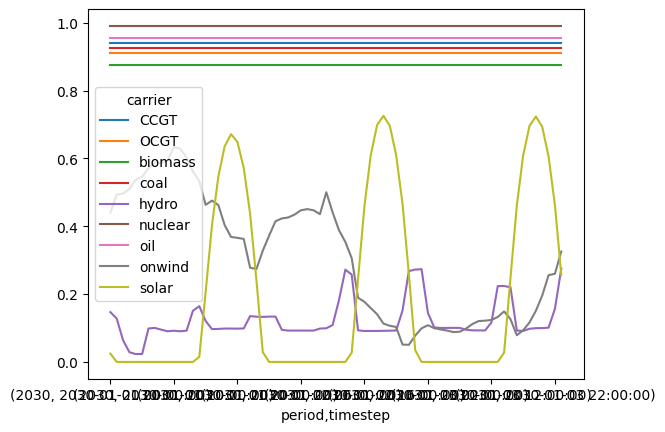

In [ ]:
network.generators_t.p_max_pu.loc[network.snapshots[0:7*24]].T.groupby(network.generators.carrier).mean().T.iloc[:72].plot()

In [20]:
# Track and set all extendable attributes to False for all components in the network
extendable_attrs_backup = {}

for component in network.components.keys():
    extendable_attrs_backup[component] = {}
    for attr in ["p_nom_extendable", "s_nom_extendable", "e_nom_extendable"]:
        if attr in network.df(component).columns:
            # Backup the current state of the attribute
            extendable_attrs_backup[component][attr] = network.df(component)[attr].copy()
            # Set the attribute to False
            network.df(component)[attr] = False

Remember our load is for 2030, so lets reduce the system load for the sake of this simulation feasibility

In [21]:
network.loads_t.p_set *= 0.75

In [22]:
network.snapshots

MultiIndex([(2030, '2030-01-01 00:00:00'),
            (2030, '2030-01-01 01:00:00'),
            (2030, '2030-01-01 02:00:00'),
            (2030, '2030-01-01 03:00:00'),
            (2030, '2030-01-01 04:00:00'),
            (2030, '2030-01-01 05:00:00'),
            (2030, '2030-01-01 06:00:00'),
            (2030, '2030-01-01 07:00:00'),
            (2030, '2030-01-01 08:00:00'),
            (2030, '2030-01-01 09:00:00'),
            ...
            (2030, '2030-12-31 14:00:00'),
            (2030, '2030-12-31 15:00:00'),
            (2030, '2030-12-31 16:00:00'),
            (2030, '2030-12-31 17:00:00'),
            (2030, '2030-12-31 18:00:00'),
            (2030, '2030-12-31 19:00:00'),
            (2030, '2030-12-31 20:00:00'),
            (2030, '2030-12-31 21:00:00'),
            (2030, '2030-12-31 22:00:00'),
            (2030, '2030-12-31 23:00:00')],
           name='snapshot', length=8760)

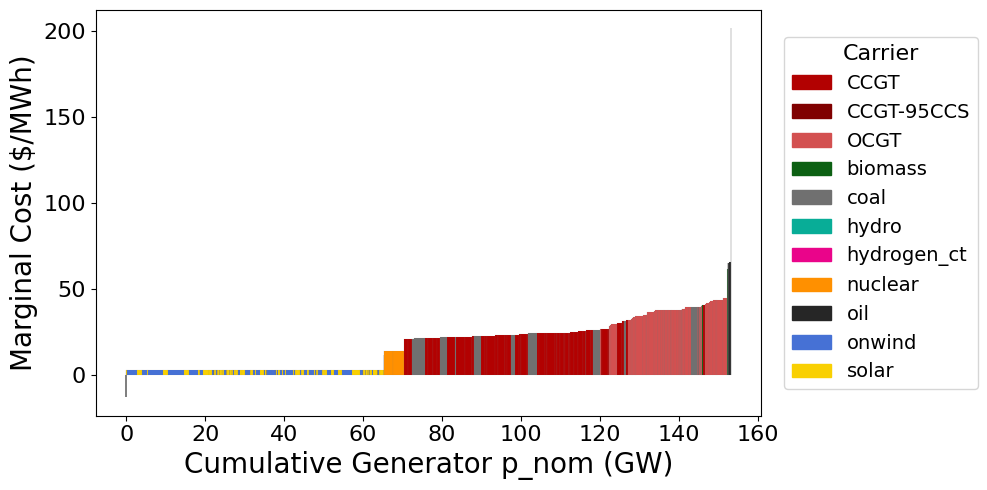

In [23]:
plot_generator_marginal_costs(network)

<Axes: xlabel='period,timestep'>

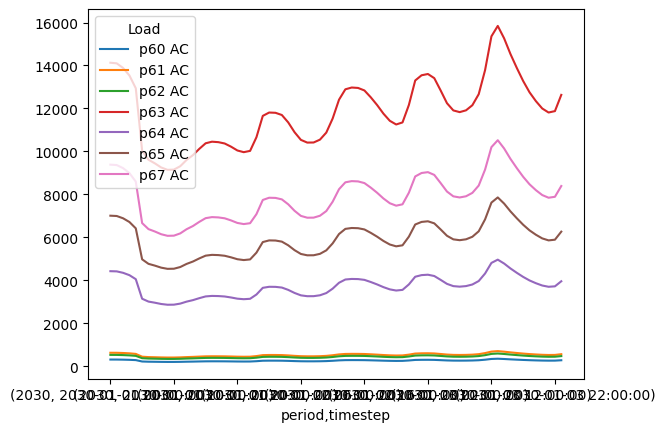

In [24]:
network.loads_t.p_set.iloc[:72].plot()

<Axes: xlabel='period,timestep'>

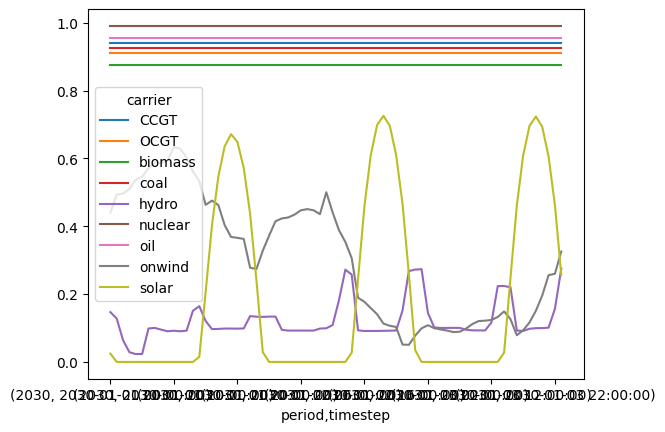

In [25]:
network.generators_t.p_max_pu.loc[network.snapshots[0:7*24]].T.groupby(network.generators.carrier).mean().T.iloc[:72].plot()

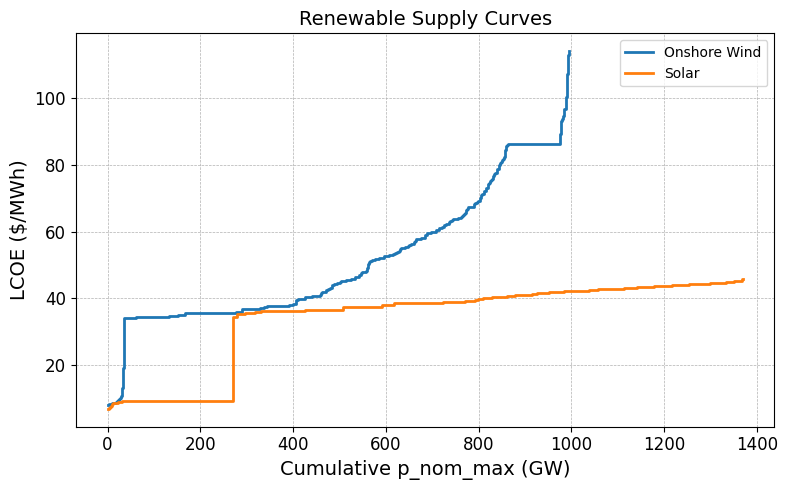

In [70]:
# LCOE = (capital_cost + opex) / (p_nom * capacity_factor * 8760)
lcoes = (network.generators.capital_cost) / (network.generators_t.p_max_pu.mean(axis=0) * 8760)
network.generators['lcoe'] = lcoes

carriers = ["onwind", "solar"]
carrier_labels = {"onwind": "Onshore Wind", "solar": "Solar", "offwind": "Offshore Wind"}
carrier_colors = {"onwind": "tab:blue", "solar": "tab:orange", "offwind": "tab:green"}

plt.figure(figsize=(8, 5))

for carrier in carriers:
    gens = network.generators[
        (network.generators.carrier == carrier) 
    ].copy()
    gens = gens.sort_values("lcoe")
    cumulative = gens["p_nom_max"].cumsum() / 1e3
    plt.step(
        cumulative,
        gens["lcoe"],
        where="post",
        label=carrier_labels[carrier],
        color=carrier_colors[carrier],
        linewidth=2,
    )

plt.xlabel("Cumulative p_nom_max (GW)", fontsize=14)
plt.ylabel("LCOE ($/MWh)", fontsize=14)
plt.title("Renewable Supply Curves", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
network.optimize.create_model(
    snapshots=network.snapshots[0:1],
    multi_investment_periods=True,
)

Linopy LP model

Variables:
----------
 * Generator-p (snapshot, period, timestep, Generator)
 * Link-p (snapshot, period, timestep, Link)
 * StorageUnit-p_dispatch (snapshot, period, timestep, StorageUnit)
 * StorageUnit-p_store (snapshot, period, timestep, StorageUnit)
 * StorageUnit-state_of_charge (snapshot, period, timestep, StorageUnit)

Constraints:
------------
 * Generator-fix-p-lower (snapshot, period, timestep, Generator-fix)
 * Generator-fix-p-upper (snapshot, period, timestep, Generator-fix)
 * Generator-fix-p-ramp_limit_up (snapshot, period, timestep, Generator-fix)
 * Generator-fix-p-ramp_limit_down (snapshot, period, timestep, Generator-fix)
 * Link-fix-p-lower (snapshot, period, timestep, Link-fix)
 * Link-fix-p-upper (snapshot, period, timestep, Link-fix)
 * StorageUnit-fix-p_dispatch-lower (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-p_dispatch-upper (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-p_store-lower (snapshot, period, 

In [28]:
network.optimize.solve_model(solver_name="gurobi")
network.optimize.assign_solution()

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io: Writing time: 0.11s


Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-01
Read LP format model from file /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-problem-fk3feiur.lp
Reading time = 0.01 seconds
obj: 2823 rows, 1401 columns, 4246 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 24.6.0 24G90)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2823 rows, 1401 columns and 4246 nonzeros
Model fingerprint: 0xd67b29e4
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [1e+01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+04]
Presolve removed 2816 rows and 1270 columns
Presolve time: 0.01s
Presolved: 7 rows, 131 columns, 153 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6521597e+04   4.460024e+03   0.000000e+00      0s
      14    3

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1401 primals, 2823 duals
Objective: 3.80e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


In [29]:
# The above sequence of commands is equivalent to:
network.optimize(
    snapshots=network.snapshots[0:1],
    solver_name='gurobi'
)

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io: Writing time: 0.11s


Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-01
Read LP format model from file /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-problem-cyibs5as.lp
Reading time = 0.01 seconds
obj: 2859 rows, 1419 columns, 4300 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 24.6.0 24G90)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2859 rows, 1419 columns and 4300 nonzeros
Model fingerprint: 0x997a362b
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [1e+01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+04]
Presolve removed 2852 rows and 1282 columns
Presolve time: 0.01s
Presolved: 7 rows, 137 columns, 159 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6521597e+04   4.460024e+03   0.000000e+00      0s
      14    3

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1419 primals, 2859 duals
Objective: 3.80e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

<Axes: xlabel='carrier'>

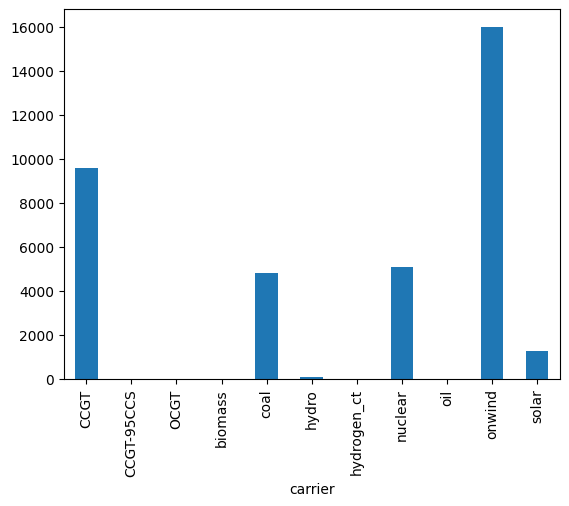

In [30]:
# lets look at the results
network.generators_t.p.loc[network.snapshots[0]].groupby(network.generators.carrier).sum().plot(kind="bar")
# only the first time step is solved!

 Great! Most market simulations aren't limited to a single time-step. 
 Let's solve a week of the economic dispatch problem. With multiple time-steps, 
 new constraints are introduced into the formulation:
 - Generator Ramping Constraint
 - Storage Unit State-of-Charge Limit
 - Storage Unit Charge and Discharge Limits
 - Storage Unit Energy Evolution Constraint

 and (if you weren't paying attention) we actually had transmission lines in the last problem! so lets add line flow constraints

$$
\begin{aligned}
\min_{p,\;s^{in},\;s^{out},\;SOC} \quad 
& \sum_{t \in T} \sum_{g \in G} o_{g,t}\, p_{g,t} \\[0.5em]
\text{subject to:} \quad
& p_{g,t} \le \widetilde{p}^{\max}_{g,t}\,\overline{P}_{g} 
&& \forall g \in G,\; t \in T \\[0.5em]
& RD_g \le p_{g,t} - p_{g,t-1} \le RU_g 
&& \forall g \in G,\; t \in T \\[0.5em]
& 0 \le SOC_{s,t} \le h_s\,\overline{S}_{s} 
&& \forall s \in S,\; t \in T \\[0.5em]
& 0 \le s^{out}_{s,t} \le \overline{S}_{s} 
&& \forall s \in S,\; t \in T \\[0.5em]
& 0 \le s^{in}_{s,t} \le \overline{S}_{s} 
&& \forall s \in S,\; t \in T \\[0.5em]
& SOC_{s,t} = SOC_{s,t-1} + \eta^{in}\, s^{in}_{s,t} - \frac{1}{\eta^{out}}\, s^{out}_{s,t} 
&& \forall s \in S,\; t \in T \\[0.5em]
& \widetilde{f}_{b,t}^{\text{min}} \bar{f}_{b} 
  \leq f_{b,t} 
  \leq \widetilde{f}_{b,t}^{\text{max}} \bar{f}_{b} 
  && \forall b \in B,\; t \in T_a     \\[0.5em]
& \sum_{g \in G} p_{g,t,n}
  + \sum_{s \in S} s^{out}_{s,t,n}
  - \sum_{s \in S} s^{in}_{s,t,n}
  = D_{t,n}
&& \forall n \in N,\; t \in T
\end{aligned}
$$


In [31]:
network.optimize(
    snapshots=network.snapshots[0:7*24],
    solver_name='gurobi'
)

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 11.20it/s]
INFO:linopy.io: Writing time: 3.85s


Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-01
Read LP format model from file /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-problem-cwv9wpyv.lp
Reading time = 0.98 seconds
obj: 626270 rows, 238392 columns, 1017837 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 24.6.0 24G90)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 626270 rows, 238392 columns and 1017837 nonzeros
Model fingerprint: 0x8487fa25
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [1e+01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 2e+04]
Presolve removed 623584 rows and 210329 columns
Presolve time: 0.36s
Presolved: 2686 rows, 28397 columns, 36289 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statist

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 238392 primals, 626270 duals
Objective: 4.22e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [32]:
network.generators_t.p.loc[network.snapshots[0:7*24]].T.groupby(network.generators.carrier).sum()

period                     2030                                          \
timestep    2030-01-01 00:00:00 2030-01-01 01:00:00 2030-01-01 02:00:00   
carrier                                                                   
CCGT                7030.546300         6763.047095           7030.5463   
CCGT-95CCS             0.000000            0.000000              0.0000   
OCGT                   0.000000            0.000000              0.0000   
biomass                0.000000            0.000000              0.0000   
coal                4644.661660         4420.089747           3136.2101   
hydro                 90.600000           78.900000             39.3000   
hydrogen_ct            0.000000            0.000000              0.0000   
nuclear             5089.845200         5089.845200           5089.8452   
oil                    0.000000            0.000000              0.0000   
onwind             15992.613303        17793.370550          19917.8128   
solar               1261.878195            0.000000              0.0000   

period                                                                   \
timestep    2030-01-01 03:00:00 2030-01-01 04:00:00 2030-01-01 05:00:00   
carrier                                                                   
CCGT                4211.524552         1566.043800            0.000000   
CCGT-95CCS             0.000000            0.000000            0.000000   
OCGT                   0.000000            0.000000            0.000000   
biomass                0.000000            0.000000            0.000000   
coal                3136.210100         3006.828107            0.000000   
hydro                 17.600000           14.300000           14.400000   
hydrogen_ct            0.000000            0.000000            0.000000   
nuclear             5089.845200         4619.664949         3829.914949   
oil                    0.000000            0.000000            0.000000   
onwind             22955.026937        24758.397471        25270.383964   
solar                  0.000000            0.000000            0.000000   

period                                                                   \
timestep    2030-01-01 06:00:00 2030-01-01 07:00:00 2030-01-01 08:00:00   
carrier                                                                   
CCGT                   0.000000            0.000000            0.000000   
CCGT-95CCS             0.000000            0.000000            0.000000   
OCGT                   0.000000            0.000000            0.000000   
biomass                0.000000            0.000000            0.000000   
coal                   0.000000            0.000000            0.000000   
hydro                 60.829692           61.814918           58.682427   
hydrogen_ct            0.000000            0.000000            0.000000   
nuclear             3040.164949         2659.845200         2659.845200   
oil                    0.000000            0.000000            0.000000   
onwind             26428.450776        26492.946467        25626.412420   
solar                  0.000000            0.000000            0.000000   

period                           ...                                          \
timestep    2030-01-01 09:00:00  ... 2030-01-07 14:00:00 2030-01-07 15:00:00   
carrier                          ...                                           
CCGT                   0.000000  ...         6862.370961         6419.909533   
CCGT-95CCS             0.000000  ...            0.000000            0.000000   
OCGT                   0.000000  ...            0.000000            0.000000   
biomass                0.000000  ...            0.000000            0.000000   
coal                   0.000000  ...         4796.692300         4796.692300   
hydro                 55.783400  ...          168.101805          167.040014   
hydrogen_ct            0.000000  ...            0.000000            0.000000   
nuclear             2720.595200  ...         50

But this only includes generators! we have storage units in out model and potentially stores, links, etc in other models!

In [33]:
network.carriers.loc['AC_exp', 'color'] = "#000000"

/Users/kamrantehranchi/Local_Documents/energy310_notebooks/.venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



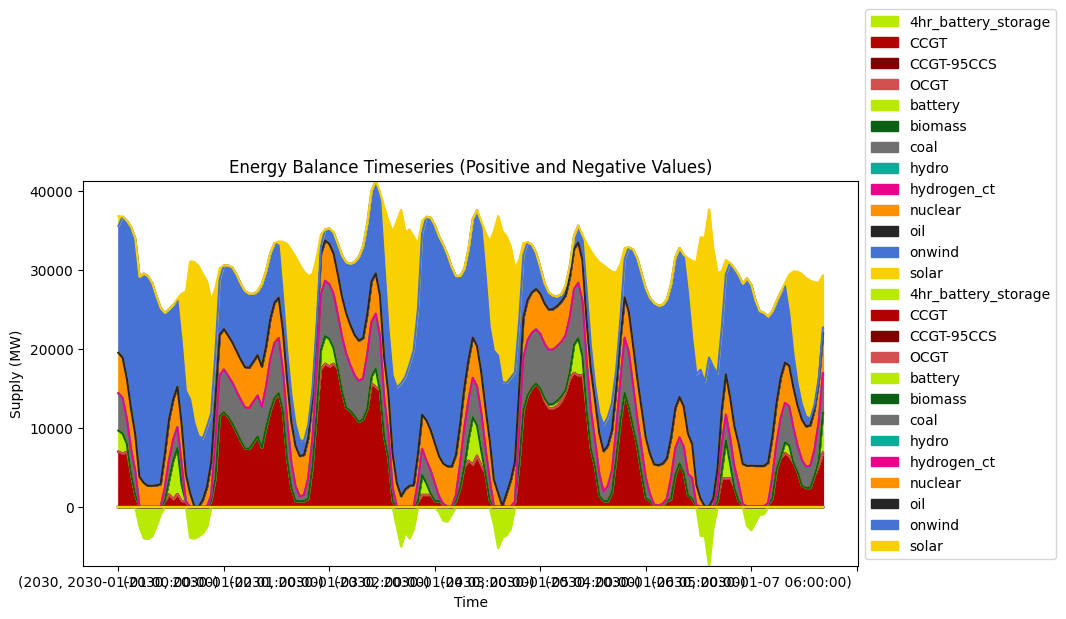

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Energy Balance Timeseries (Positive and Negative Values)'}, xlabel='Time', ylabel='Supply (MW)'>)

In [34]:
plot_energy_balance(network, 7*24)

In [35]:
network.statistics()

Optimal Capacity Installed Capacity  \
                                                    2030               2030   
Generator   Biomass                              137.000            137.000   
            Ccgt-95Ccs                               NaN                NaN   
            Coal                               14329.700          14329.700   
            Combined-Cycle Gas                 41404.100          41404.100   
            Hydrogen Combustion Turbine              NaN                NaN   
            Nuclear                             5138.600           5138.600   
            Oil                                  799.800            799.800   
            Onshore Wind                       34363.600          34363.600   
            Open-Cycle Gas                     17071.700          17071.700   
            Reservoir & Dam                      555.100            555.100   
            Solar                              30326.000          30326.000   
Link        Ac                                 99247.628          99247.628   
Load        Ac                                     0.000              0.000   
StorageUnit 4Hr_Battery_Storage                      NaN                NaN   
            Battery Storage                    10332.200          10332.200   

                                               Supply    Withdrawal  \
                                                 2030          2030   
Generator   Biomass                               NaN           NaN   
            Ccgt-95Ccs                            NaN           NaN   
            Coal                         5.425517e+05           NaN   
            Combined-Cycle Gas           9.279408e+05           NaN   
            Hydrogen Combustion Turbine           NaN           NaN   
            Nuclear                      7.611423e+05           NaN   
            Oil                                   NaN           NaN   
            Onshore Wind                 1.974726e+06           NaN   
            Open-Cycle Gas                        NaN           NaN   
            Reservoir & Dam              1.757800e+04           NaN   
            Solar                        9.198583e+05           NaN   
Link        Ac                                    NaN  2.944374e+06   
Load        Ac                                    NaN  5.062156e+06   
StorageUnit 4Hr_Battery_Storage                   NaN           NaN   
            Battery Storage              8.480677e+04  9.977267e+04   

                                        Energy Balance  Transmission  \
                                                  2030          2030   
Generator   Biomass                                NaN  0.000000e+00   
            Ccgt-95Ccs                             NaN  0.000000e+00   
            Coal                          5.425517e+05  0.000000e+00   
            Combined-Cycle Gas            9.279408e+05  0.000000e+00   
            Hydrogen Combustion Turbine            NaN  0.000000e+00   
            Nuclear                       7.611423e+05  0.000000e+00   
            Oil                                    NaN  0.000000e+00   
            Onshore Wind                  1.974726e+06  0.000000e+00   
            Open-Cycle Gas                         NaN  0.000000e+00   
            Reservoir & Dam               1.757800e+04  0.000000e+00   
            Solar                         9.198583e+05  0.000000e+00   
Link        Ac                           -2.944374e+06  2.944374e+06   
Load        Ac                           -5.062156e+06  0.000000e+00   
StorageUnit 4Hr_Battery_Storage                    NaN  0.000000e+00   
            Battery Storage              -1.496590e+04  0.000000e+00   

                                        Capacity Factor   Curtailment  \
                                                   2030          2030   
Generator   Biomass                                 NaN  1.077287e+06   
            Ccgt-95Ccs                      

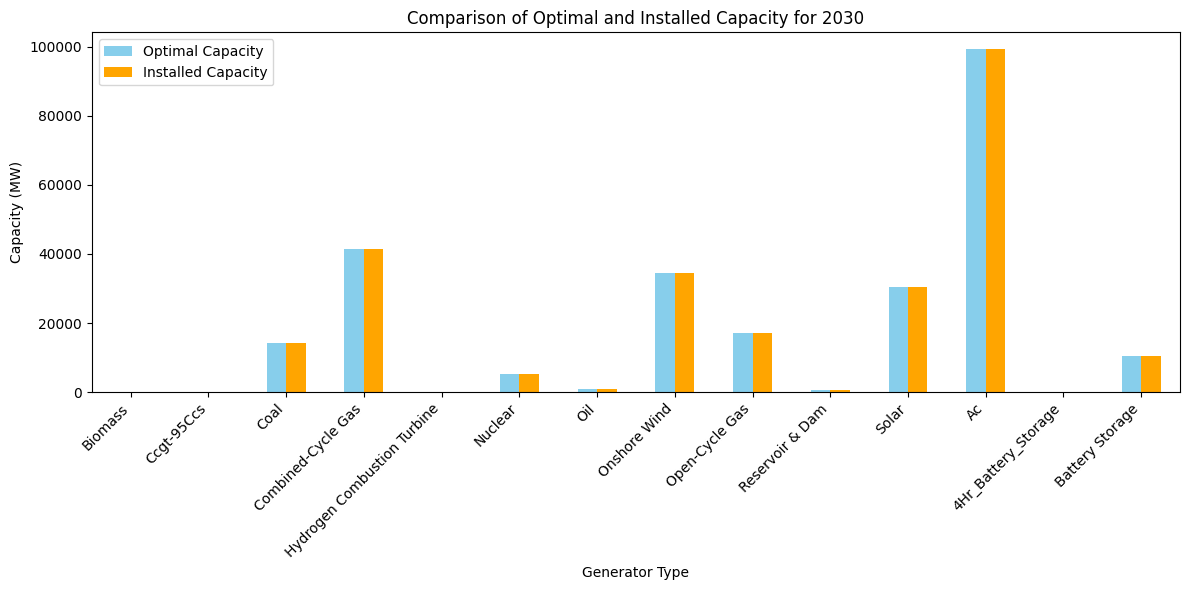

In [36]:
plot_capacity_comparison(network)

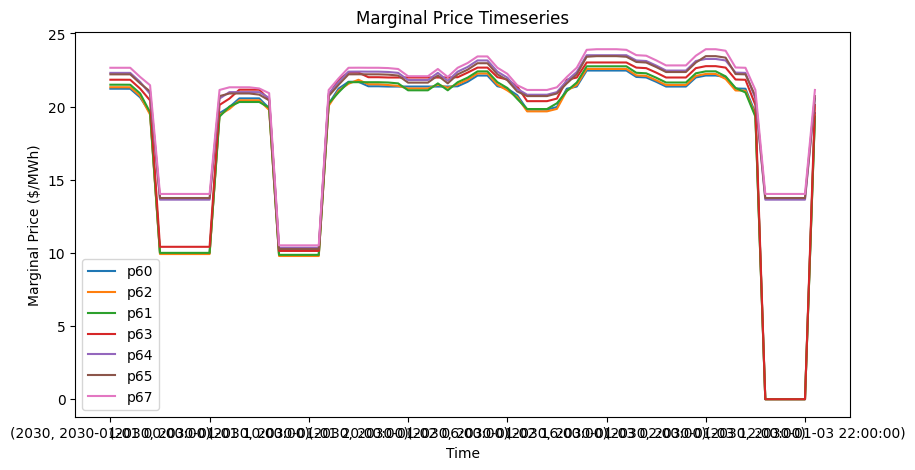

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
network.buses_t.marginal_price.iloc[:72].plot(ax=ax)
ax.set_title("Marginal Price Timeseries")
ax.set_ylabel("Marginal Price ($/MWh)")
ax.set_xlabel("Time")
plt.show()


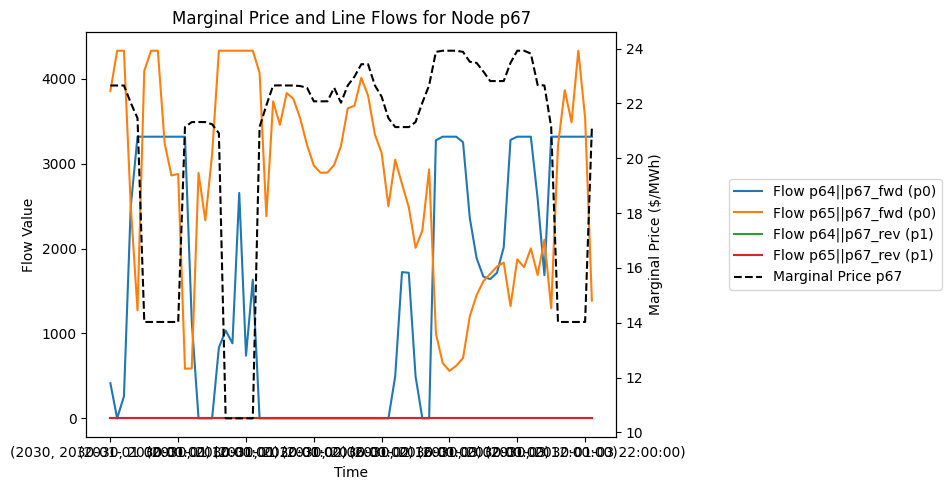

In [38]:
fig, ax1 = plt.subplots(figsize=(10, 5))

node = 'p67'
# Create a second y-axis for the marginal price
ax2 = ax1.twinx()

# Plot marginal price for node p64 as a dotted line on the second y-axis
network.buses_t.marginal_price[node].iloc[:72].plot(ax=ax2, linestyle='--', color='black', label='Marginal Price '+node)

# Find links connected to node p64
links_p64 = network.links[(network.links['bus0'] == node) | (network.links['bus1'] == node)]

# Plot line flows for links connected to node p64
for link in links_p64.index:
    if 'fwd' in link:
        network.links_t.p0[link].iloc[:72].plot(ax=ax1, label=f'Flow {link} (p0)')
    elif 'rev' in link:
        network.links_t.p1[link].iloc[:72].plot(ax=ax1, label=f'Flow {link} (p1)')
    # break

ax1.set_title("Marginal Price and Line Flows for Node "+node)
ax1.set_ylabel("Flow Value")
ax1.set_xlabel("Time")
ax2.set_ylabel("Marginal Price ($/MWh)")

# Combine legends from both y-axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.2, 0.5))

plt.tight_layout()
plt.show()

### Network Clustering Example

Lets make this a single node ("Copper plate") network via the pypsa.clustering functionality

In [39]:
busmap = network.buses.interconnect
cols = ['Pd', 'country', 'reeds_zone']
[network.buses.drop(columns=col, inplace=True) for col in cols if col in network.buses.columns]
clustered_network = network.cluster.cluster_by_busmap(busmap)

       'p61||p63_fwd', 'p61||p64_fwd', 'p61||p65_fwd', 'p63||p64_fwd',
       'p64||p65_fwd', 'p64||p67_fwd', 'p65||p67_fwd', 'p60||p61_rev',
       'p60||p62_rev', 'p60||p63_rev', 'p61||p62_rev', 'p61||p63_rev',
       'p61||p64_rev', 'p61||p65_rev', 'p63||p64_rev', 'p64||p65_rev',
       'p64||p67_rev', 'p65||p67_rev'],
      dtype='object', name='Link') for attribute p0 of Link are not in main components dataframe links
       'p61||p63_fwd', 'p61||p64_fwd', 'p61||p65_fwd', 'p63||p64_fwd',
       'p64||p65_fwd', 'p64||p67_fwd', 'p65||p67_fwd', 'p60||p61_rev',
       'p60||p62_rev', 'p60||p63_rev', 'p61||p62_rev', 'p61||p63_rev',
       'p61||p64_rev', 'p61||p65_rev', 'p63||p64_rev', 'p64||p65_rev',
       'p64||p67_rev', 'p65||p67_rev'],
      dtype='object', name='Link') for attribute p1 of Link are not in main components dataframe links


In [40]:
clustered_network

PyPSA Network 'Unnamed Network'
-------------------------------
Components:
 - Bus: 1
 - Carrier: 17
 - Generator: 1355
 - GlobalConstraint: 1
 - Load: 7
 - StorageUnit: 14
 - SubNetwork: 1
Snapshots: 8760

In [41]:
clustered_network.optimize(snapshots=clustered_network.snapshots[0:72], solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 20.97it/s]
INFO:linopy.io: Writing time: 1.61s


Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-01
Read LP format model from file /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-problem-toswzif6.lp
Reading time = 0.38 seconds
obj: 264302 rows, 100584 columns, 428877 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 24.6.0 24G90)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 264302 rows, 100584 columns and 428877 nonzeros
Model fingerprint: 0x20bac07a
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [1e+01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 4e+04]
Presolve removed 263584 rows and 97547 columns
Presolve time: 0.11s
Presolved: 718 rows, 3179 columns, 4975 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 100584 primals, 264302 duals
Objective: 1.92e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

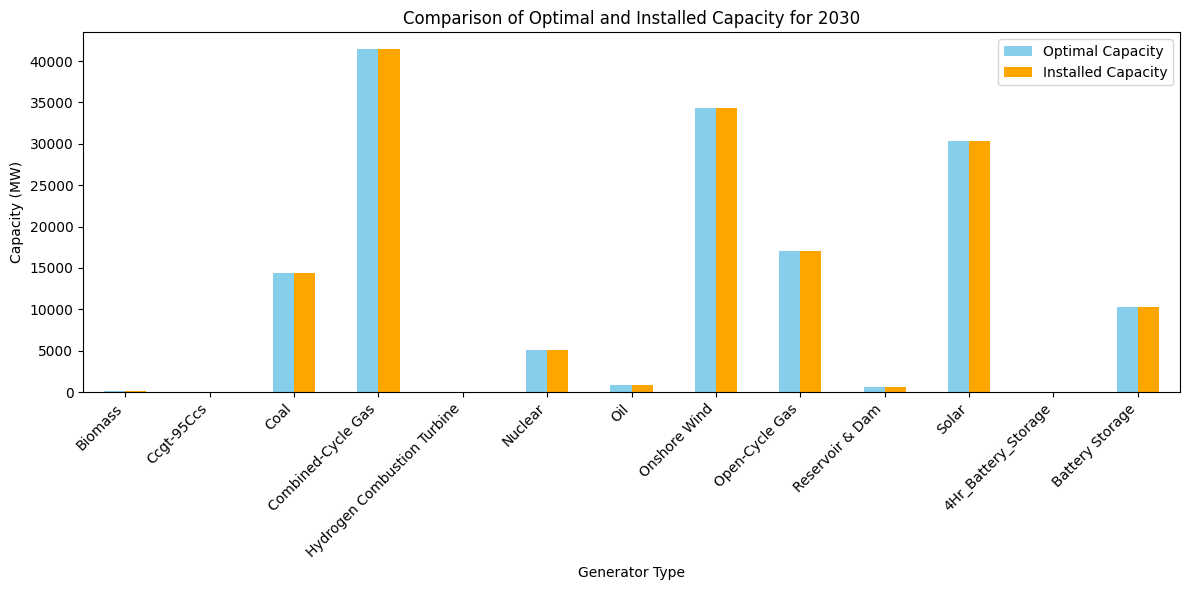

In [42]:
plot_capacity_comparison(clustered_network)

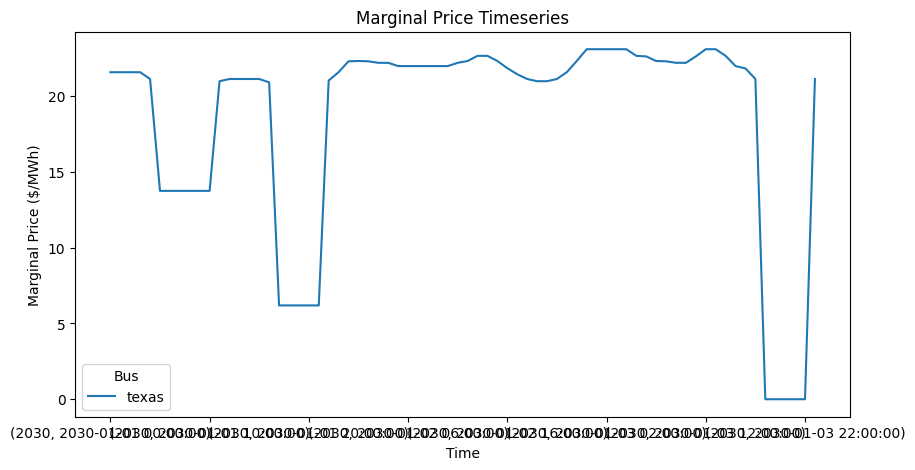

In [43]:
fig, ax = plt.subplots(figsize=(10, 5))
clustered_network.buses_t.marginal_price.iloc[:72].plot(ax=ax)
ax.set_title("Marginal Price Timeseries")
ax.set_ylabel("Marginal Price ($/MWh)")
ax.set_xlabel("Time")
plt.show()


/Users/kamrantehranchi/Local_Documents/energy310_notebooks/.venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



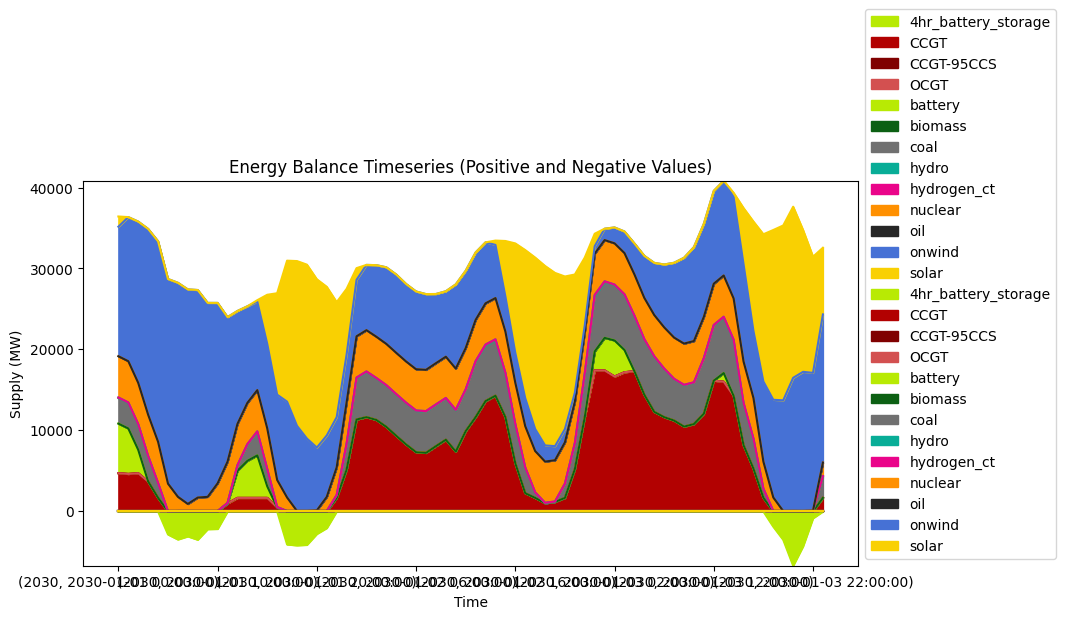

In [44]:
fig_pr, ax_pr = plot_energy_balance(clustered_network, 24 * 3)

## Now lets make this a capacity expansion problem

$$
\begin{aligned}
\min_{p, s, \bar{p}, \bar{s}, \bar{f}, f}
&\sum_{a \in A} \omega_a \Bigg[ 
\sum_{t \in T^a} \omega_{a,t} \Bigg( 
\sum_{g \in G} o_{g,a,t} \cdot p_{g,a,t} 
\Bigg) \\[0.5em]
& \quad + \sum_{g \in G} c_{g,a} \cdot \bar{p}_{g} 
+ \sum_{s \in S} c_s \cdot \bar{s}_{s} 
+ \sum_{b \in B} c_b \cdot \bar{f}_{b}
\Bigg] \\[0.5em]
\text{subject to:} \quad
&\widetilde{p}_{g,a,t}^{\text{min}} \bar{p}_{g} 
  \leq p_{g,a,t} 
  \leq \widetilde{p}_{g,a,t}^{\text{max}} \bar{p}_{g} 
  && \forall g \in G,\; a \in A,\; t \in T_a \\[0.5em]
& RD_g \leq p_{g,a,t} - p_{g,a,{t-1}} \leq RU_g 
  && \forall g \in G,\; a \in A,\; t \in T_a   \\[0.5em]
& \sum_{g \in G_z} \bar{p}_{g} \leq \bar{p}^{\text{max}}_{g,z} 
  && \forall z \in Z     \\[0.5em]
& 0 \leq SOC_{s,a,t} \leq h_s \bar{s}_{s} 
  && \forall s \in S,\; a \in A,\; t \in T_a    \\[0.5em]
& 0 \leq s_{s,a,t}^{out} \leq \bar{s}_{s} 
  && \forall s \in S,\; a \in A,\; t \in T_a     \\[0.5em]
& 0 \leq s_{s,a,t}^{in} \leq \bar{s}_{s} 
  && \forall s \in S,\; a \in A,\; t \in T_a      \\[0.5em]
& SOC_{s,a,t} = SOC_{s,a,t-1} 
  + \eta^{in} s_{s,a,t}^{in} 
  - \frac{1}{\eta^{out}} s_{s,a,t}^{out} 
  && \forall s \in S,\; a \in A,\; t \in T_a      \\[0.5em]
& \widetilde{f}_{b,a,t}^{\text{min}} \bar{f}_{b} 
  \leq f_{b,a,t} 
  \leq \widetilde{f}_{b,a,t}^{\text{max}} \bar{f}_{b} 
  && \forall b \in B,\; a \in A,\; t \in T_a     \\[0.5em]
& \sum_g p_{g,a,t,n} 
+ \sum_s s_{s,a,t,n}^{out} 
- \sum_s s_{s,a,t,n}^{in} 
- \sum_b K_{b,n} f_{b,a,t}  = D_{a,t,n}  \forall n \in N,\; a \in A,\; t \in T_a
\end{aligned}
$$

In [45]:
network.generators.p_nom_extendable

Generator
p600 0 CCGT existing      False
p600 0 OCGT existing      False
p600 0 oil                False
p600 0 onwind existing    False
p600 0 solar existing     False
                          ...  
p62 hydrogen_ct_2030      False
p63 hydrogen_ct_2030      False
p64 hydrogen_ct_2030      False
p65 hydrogen_ct_2030      False
p67 hydrogen_ct_2030      False
Name: p_nom_extendable, Length: 1355, dtype: bool

In [46]:
#restore the original extendable attributes
for component, attributes in extendable_attrs_backup.items():
    for attr, original_value in attributes.items():
        network.df(component)[attr] = original_value


<Axes: xlabel='period,timestep'>

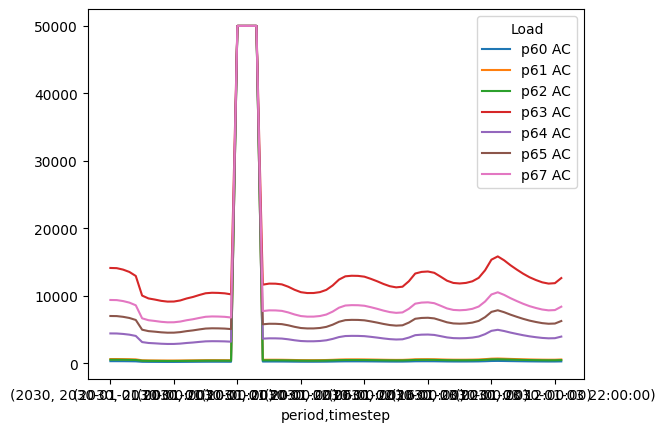

In [47]:
# network.loads_t.p_set /= 0.75
network.loads_t.p_set.iloc[20:24] = 50000 # set arbitrarily large load for 4 hour to show impacts of expansion
network.loads_t.p_set.iloc[:72].plot()


In [48]:
network.links

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
p60||p61_fwd,p60,p61,,AC,0.987274,True,0,inf,4270.071,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,4270.071
p60||p62_fwd,p60,p62,,AC,0.993721,True,0,inf,3303.403,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,3303.403
p60||p63_fwd,p60,p63,,AC,0.971904,True,0,inf,10383.198,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,10383.198
p61||p62_fwd,p61,p62,,AC,0.992017,True,0,inf,1522.014,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1522.014
p61||p63_fwd,p61,p63,,AC,0.960224,True,0,inf,3393.601,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,3393.601
p61||p64_fwd,p61,p64,,AC,0.967756,True,0,inf,3008.900,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,3008.900
p61||p65_fwd,p61,p65,,AC,0.970447,True,0,inf,186.352,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,186.352
p63||p64_fwd,p63,p64,,AC,0.978866,True,0,inf,7909.854,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,7909.854
p64||p65_fwd,p64,p65,,AC,0.991812,True,0,inf,6488.427,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,6488.427


In [49]:
network.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt,vom_cost,fuel_cost,heat_rate,carrier_base,land_region,lcoe
Generator,,,,,,,,,,,,,,,,,,,,,
p600 0 CCGT existing,p60,Slack,,1869.9,0.0,True,0.0,1869.9,0.0,1.0,...,1.0,1.0,12.000000,1869.9,2.04,2.9163,6.238,CCGT,p600 0,3.854317
p600 0 OCGT existing,p60,,,1.2,0.0,True,0.0,1.2,0.0,1.0,...,1.0,1.0,3.000000,1.2,6.94,2.9163,9.717,OCGT,p600 0,NaN
p600 0 oil,p60,,,536.4,0.0,False,536.4,inf,0.0,1.0,...,1.0,1.0,6.000000,536.4,NaN,4.6147,NaN,oil,p600 0,0.000000
p600 0 onwind existing,p60,,,3682.8,0.0,False,0.0,3682.8,0.0,1.0,...,1.0,1.0,16057.082123,3682.8,NaN,NaN,NaN,onwind,p600 0,8.547748
p600 0 solar existing,p60,,,1345.8,0.0,False,0.0,1345.8,0.0,1.0,...,1.0,1.0,9405.538610,1345.8,NaN,NaN,NaN,solar,p600 0,7.501475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p62 hydrogen_ct_2030,p62,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,1.0,1.0,1.000000,0.0,NaN,NaN,NaN,,,NaN
p63 hydrogen_ct_2030,p63,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,1.0,1.0,1.000000,0.0,NaN,NaN,NaN,,,NaN
p64 hydrogen_ct_2030,p64,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,1.0,1.0,1.000000,0.0,NaN,NaN,NaN,,,NaN


In [50]:
network.generators.groupby("carrier").p_nom_extendable.value_counts()

carrier      p_nom_extendable
CCGT         True                 94
CCGT-95CCS   True                  7
OCGT         True                276
biomass      False                 7
coal         True                 20
hydro        False                10
hydrogen_ct  True                  7
nuclear      True                 11
oil          False                29
onwind       True                373
             False                52
solar        True                371
             False                98
Name: count, dtype: int64

In [51]:
network.optimize(snapshots=network.snapshots[0:72], solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 37.91it/s]
INFO:linopy.io: Writing time: 2.26s


Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-01
Read LP format model from file /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-problem-rim1swbi.lp
Reading time = 0.47 seconds
obj: 270032 rows, 103357 columns, 562700 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 24.6.0 24G90)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 270032 rows, 103357 columns and 562700 nonzeros
Model fingerprint: 0x433e7c0e
Coefficient statistics:
  Matrix range     [1e-03, 6e+02]
  Objective range  [1e+00, 5e+05]
  Bounds range     [5e+09, 5e+09]
  RHS range        [1e-03, 5e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 143190 rows and 30872 columns
Presolve time: 0.40s
Presolved: 126842 rows, 72485 columns, 383527 nonzeros

Concurre

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 103357 primals, 270032 duals
Objective: 2.28e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-ext-p-ramp_limit_up, Generator-ext-p-ramp_limit_down, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

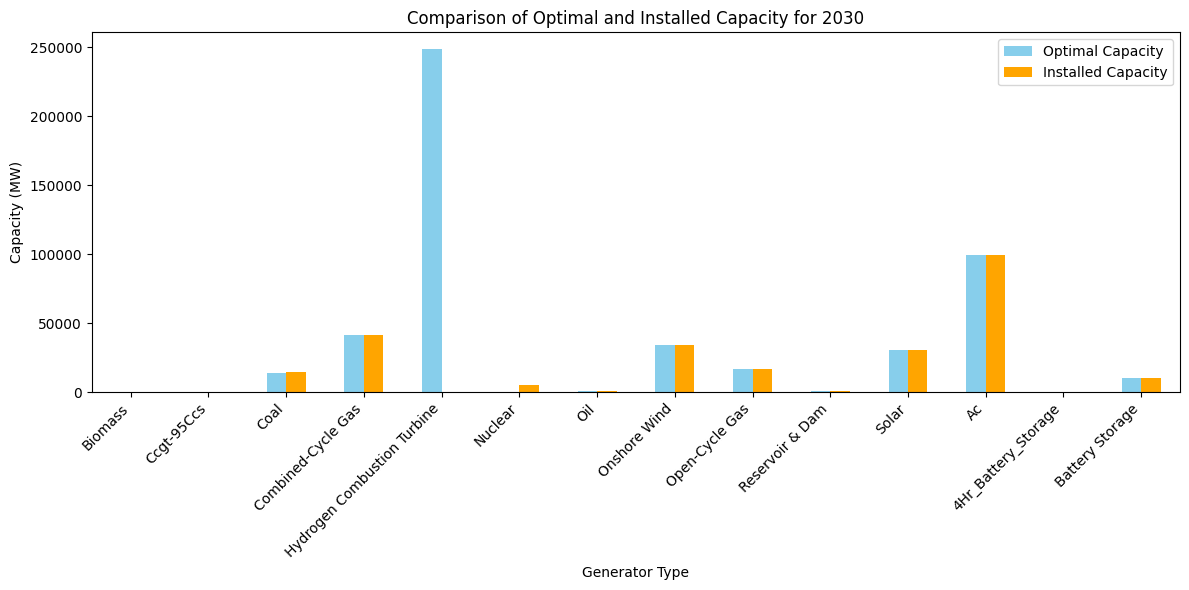

In [52]:
plot_capacity_comparison(network)

/Users/kamrantehranchi/Local_Documents/energy310_notebooks/.venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



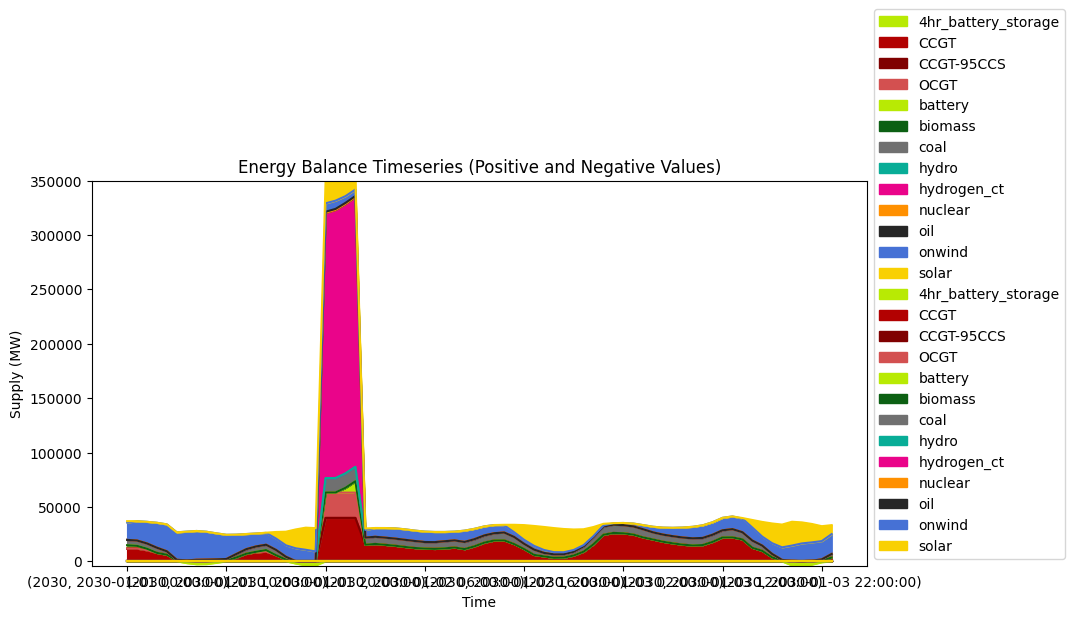

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Energy Balance Timeseries (Positive and Negative Values)'}, xlabel='Time', ylabel='Supply (MW)'>)

In [53]:
plot_energy_balance(network, 24 * 3)

#### These results should set off some alarms.... does anything look weird to you about the solution??

### Adjusting snapshot weighting

$$
\begin{aligned}
\min_{p, s, \bar{p}, \bar{s}, \bar{f}, f}
&\sum_{a \in A} \omega_a \Bigg[ 
\sum_{t \in T^a} \textcolor{red}{\omega_{a,t}} \Bigg( 
\sum_{g \in G} o_{g,a,t} \cdot p_{g,a,t} 
\Bigg) \\[0.5em]
& \quad + \sum_{g \in G} c_{g,a} \cdot \bar{p}_{g} 
+ \sum_{s \in S} c_s \cdot \bar{s}_{s} 
+ \sum_{b \in B} c_b \cdot \bar{f}_{b}
\Bigg] \\[0.5em]
\end{aligned}
$$

In [54]:
network.snapshot_weightings.iloc[0:72] = 8760/72

In [55]:
network.optimize(snapshots=network.snapshots[0:72], solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 40.40it/s]
INFO:linopy.io: Writing time: 2.26s


Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-01
Read LP format model from file /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-problem-ycdsl2fm.lp
Reading time = 0.49 seconds
obj: 270032 rows, 103357 columns, 562700 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 24.6.0 24G90)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 270032 rows, 103357 columns and 562700 nonzeros
Model fingerprint: 0xb88c1fee
Coefficient statistics:
  Matrix range     [1e-03, 6e+02]
  Objective range  [1e+00, 5e+05]
  Bounds range     [5e+09, 5e+09]
  RHS range        [1e-03, 5e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 143190 rows and 30872 columns
Presolve time: 0.41s
Presolved: 126842 rows, 72485 columns, 383527 nonzeros

Concurre

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 103357 primals, 270032 duals
Objective: 3.42e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-ext-p-ramp_limit_up, Generator-ext-p-ramp_limit_down, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

/Users/kamrantehranchi/Local_Documents/energy310_notebooks/.venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



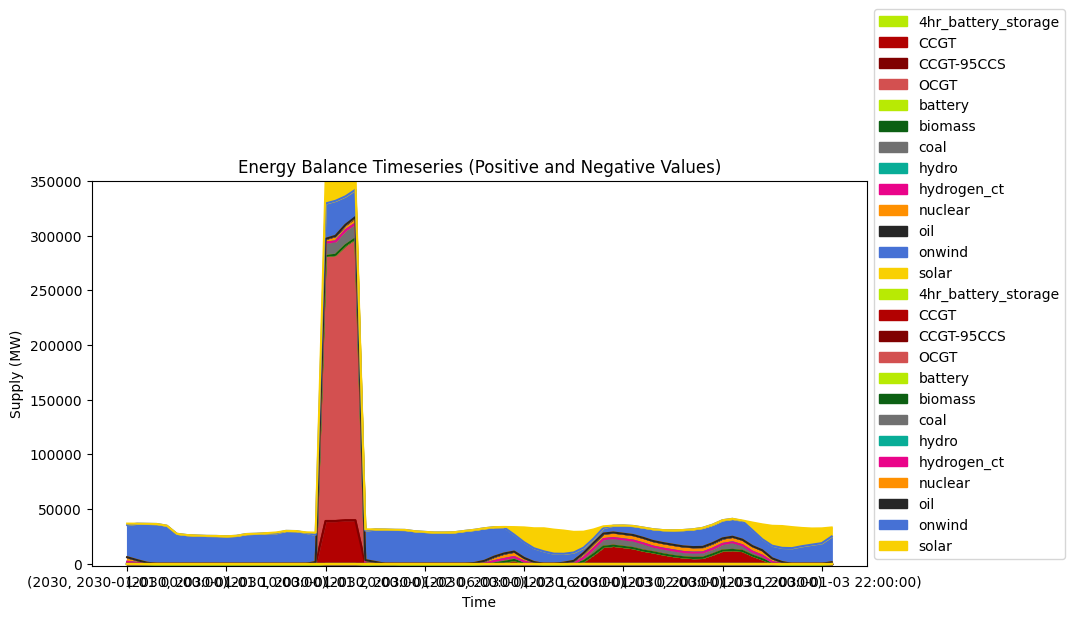

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Energy Balance Timeseries (Positive and Negative Values)'}, xlabel='Time', ylabel='Supply (MW)'>)

In [56]:
plot_energy_balance(network, 24 *3)

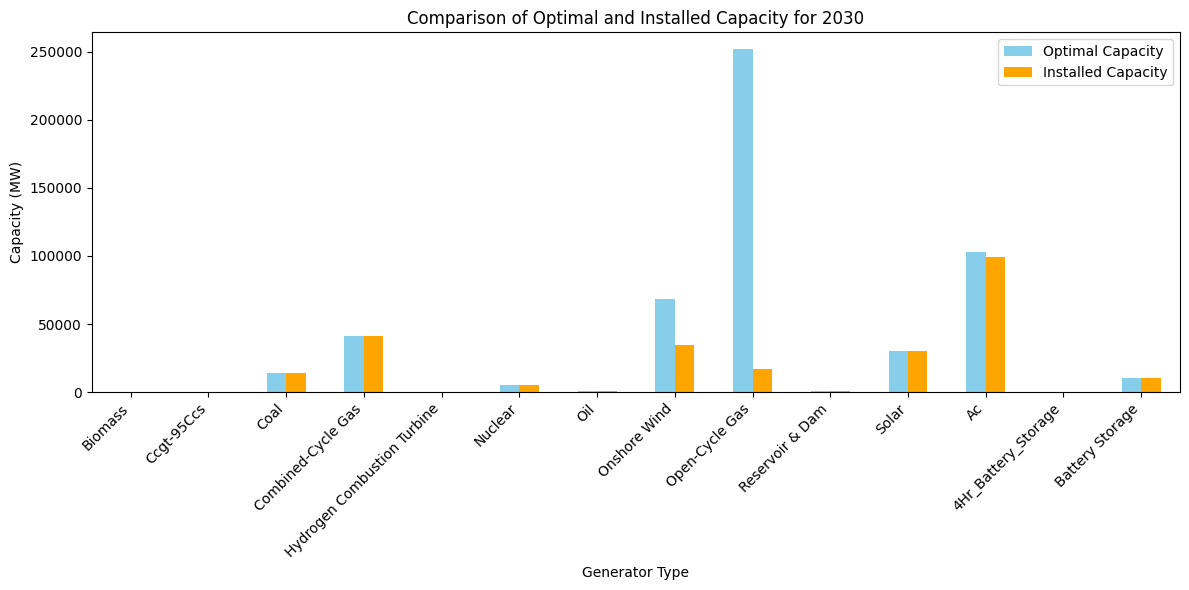

In [57]:
plot_capacity_comparison(network)

# Custom Constraints

It is often the case that we want to add custom constraints that provide functionality beyond the core functionality in the PyPSA package. These custom constraints vary widely based on your application. But lets look more closely at the linopy model to understand how we can add these custom constraints!

Lets' implement spinning reserves taken from [pypsa examples](https://pypsa.readthedocs.io/en/latest/examples/reserve-power.html#Implementing-spinning-reserve-constraints)

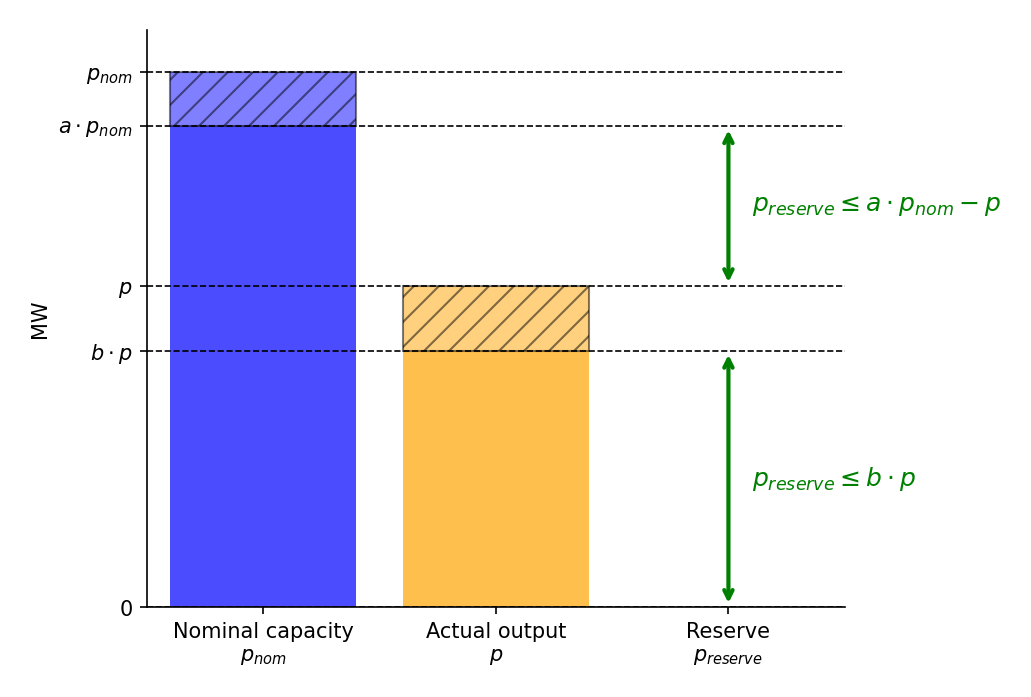

In [58]:
from IPython.display import Image, display

# Insert an image into the notebook
display(Image(filename='reserve-power-graph.webp'))


In [59]:
clustered_network.optimize.create_model(snapshots=clustered_network.snapshots[0:72], multi_investment_periods=True)
model = clustered_network.model
model

Linopy LP model

Variables:
----------
 * Generator-p (snapshot, period, timestep, Generator)
 * StorageUnit-p_dispatch (snapshot, period, timestep, StorageUnit)
 * StorageUnit-p_store (snapshot, period, timestep, StorageUnit)
 * StorageUnit-state_of_charge (snapshot, period, timestep, StorageUnit)

Constraints:
------------
 * Generator-fix-p-lower (snapshot, period, timestep, Generator-fix)
 * Generator-fix-p-upper (snapshot, period, timestep, Generator-fix)
 * Generator-fix-p-ramp_limit_up (snapshot, period, timestep, Generator-fix)
 * Generator-fix-p-ramp_limit_down (snapshot, period, timestep, Generator-fix)
 * StorageUnit-fix-p_dispatch-lower (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-p_dispatch-upper (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-p_store-lower (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-p_store-upper (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-state_of_charge-lower (snapshot, perio

In [60]:
v_rp = clustered_network.model.add_variables(
    lower=0,
    coords=[clustered_network.model.variables['Generator-p'].coords['snapshot'], clustered_network.generators.index],
    name="Generator-p_reserve",
)
# model.variables['Generator-p'].coords
v_rp

Variable (snapshot (period, timestep): 72, Generator: 1355)
-----------------------------------------------------------
[(2030, 2030-01-01 00:00:00), p600 0 CCGT existing]: Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 CCGT existing] ∈ [0, inf]
[(2030, 2030-01-01 00:00:00), p600 0 OCGT existing]: Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 OCGT existing] ∈ [0, inf]
[(2030, 2030-01-01 00:00:00), p600 0 oil]: Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 oil] ∈ [0, inf]
[(2030, 2030-01-01 00:00:00), p600 0 onwind existing]: Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 onwind existing] ∈ [0, inf]
[(2030, 2030-01-01 00:00:00), p600 0 solar existing]: Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 solar existing] ∈ [0, inf]
[(2030, 2030-01-01 00:00:00), p600 1 onwind existing]: Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 1 onwind existing] ∈ [0, inf]
[(2030, 2030-01-01 00:00:00), p600 1 solar existing]: Generator-p_reserve[(2030,

In [61]:
# set reserve requirement as 3% of the maximum load
reserve_req = clustered_network.loads_t.p_set.iloc[0:72].max().max() * 0.3 #  req = ~475

c_sum = clustered_network.model.add_constraints(
    v_rp.sum("Generator") >= reserve_req, name="GlobalConstraint-sum_of_reserves"
)
c_sum

Constraint `GlobalConstraint-sum_of_reserves` [snapshot (period, timestep): 72]:
--------------------------------------------------------------------------------
[(2030, 2030-01-01 00:00:00)]: +1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 CCGT existing] + 1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 OCGT existing] + 1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 oil] ... +1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p64 hydrogen_ct_2030] + 1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p65 hydrogen_ct_2030] + 1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p67 hydrogen_ct_2030] ≥ 4752.433215
[(2030, 2030-01-01 01:00:00)]: +1 Generator-p_reserve[(2030, 2030-01-01 01:00:00), p600 0 CCGT existing] + 1 Generator-p_reserve[(2030, 2030-01-01 01:00:00), p600 0 OCGT existing] + 1 Generator-p_reserve[(2030, 2030-01-01 01:00:00), p600 0 oil] ... +1 Generator-p_reserve[(2030, 2030-01-01 01:00:00), p64 hydrogen_ct_2030] + 1 Generator-p_reserve[(203

In [62]:
# Restrict the maximum reserve power that a generator can provide
a = 1
c_rpos = clustered_network.model.add_constraints(
    v_rp
    <= -clustered_network.model.variables["Generator-p"] + a * clustered_network.generators["p_nom"],
    name="Generator-reserve_upper_limit",
)
c_rpos

Constraint `Generator-reserve_upper_limit` [snapshot (period, timestep): 72, Generator: 1355]:
----------------------------------------------------------------------------------------------
[(2030, 2030-01-01 00:00:00), p600 0 CCGT existing]: +1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 CCGT existing] + 1 Generator-p[(2030, 2030-01-01 00:00:00), p600 0 CCGT existing]       ≤ 1869.9000000000003
[(2030, 2030-01-01 00:00:00), p600 0 OCGT existing]: +1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 OCGT existing] + 1 Generator-p[(2030, 2030-01-01 00:00:00), p600 0 OCGT existing]       ≤ 1.2000000000000002
[(2030, 2030-01-01 00:00:00), p600 0 oil]: +1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 oil] + 1 Generator-p[(2030, 2030-01-01 00:00:00), p600 0 oil]                                     ≤ 536.4
[(2030, 2030-01-01 00:00:00), p600 0 onwind existing]: +1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 onwind existing] + 1 Generator-p[(2030, 2030-0

In [63]:
# Restrict the fraction of each generator's dispatch that can be used for reserves
b = 0.5

c_rneg = clustered_network.model.add_constraints(
    v_rp <= b * clustered_network.model.variables["Generator-p"],
    name="Generator-reserve_lower_limit",
)
c_rneg

Constraint `Generator-reserve_lower_limit` [snapshot (period, timestep): 72, Generator: 1355]:
----------------------------------------------------------------------------------------------
[(2030, 2030-01-01 00:00:00), p600 0 CCGT existing]: +1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 CCGT existing] - 0.5 Generator-p[(2030, 2030-01-01 00:00:00), p600 0 CCGT existing]       ≤ -0.0
[(2030, 2030-01-01 00:00:00), p600 0 OCGT existing]: +1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 OCGT existing] - 0.5 Generator-p[(2030, 2030-01-01 00:00:00), p600 0 OCGT existing]       ≤ -0.0
[(2030, 2030-01-01 00:00:00), p600 0 oil]: +1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 oil] - 0.5 Generator-p[(2030, 2030-01-01 00:00:00), p600 0 oil]                                     ≤ -0.0
[(2030, 2030-01-01 00:00:00), p600 0 onwind existing]: +1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 onwind existing] - 0.5 Generator-p[(2030, 2030-01-01 00:00:00), p600 

In [64]:
model.constraints

linopy.model.Constraints
------------------------
 * Generator-fix-p-lower (snapshot, period, timestep, Generator-fix)
 * Generator-fix-p-upper (snapshot, period, timestep, Generator-fix)
 * Generator-fix-p-ramp_limit_up (snapshot, period, timestep, Generator-fix)
 * Generator-fix-p-ramp_limit_down (snapshot, period, timestep, Generator-fix)
 * StorageUnit-fix-p_dispatch-lower (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-p_dispatch-upper (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-p_store-lower (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-p_store-upper (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-state_of_charge-lower (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-state_of_charge-upper (snapshot, period, timestep, StorageUnit-fix)
 * Bus-nodal_balance (Bus, snapshot, period, timestep)
 * StorageUnit-energy_balance (snapshot, period, timestep, StorageUnit)
 * GlobalConstraint-sum_of_reserv

In [65]:
clustered_network.optimize.solve_model(solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 13.30it/s]
INFO:linopy.io: Writing time: 3.15s


Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-01
Read LP format model from file /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-problem-gcluu_ms.lp
Reading time = 0.76 seconds
obj: 454346 rows, 196848 columns, 905085 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 24.6.0 24G90)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 454346 rows, 196848 columns and 905085 nonzeros
Model fingerprint: 0xccfde3bf
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  Objective range  [1e+01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 4e+04]
Presolve removed 420220 rows and 161784 columns
Presolve time: 0.28s
Presolved: 34126 rows, 35206 columns, 103890 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statist

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 196848 primals, 454346 duals
Objective: 1.93e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, GlobalConstraint-sum_of_reserves, Generator-reserve_upper_limit, Generator-reserve_lower_limit were not assigned to the network.


('ok', 'optimal')

/Users/kamrantehranchi/Local_Documents/energy310_notebooks/.venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



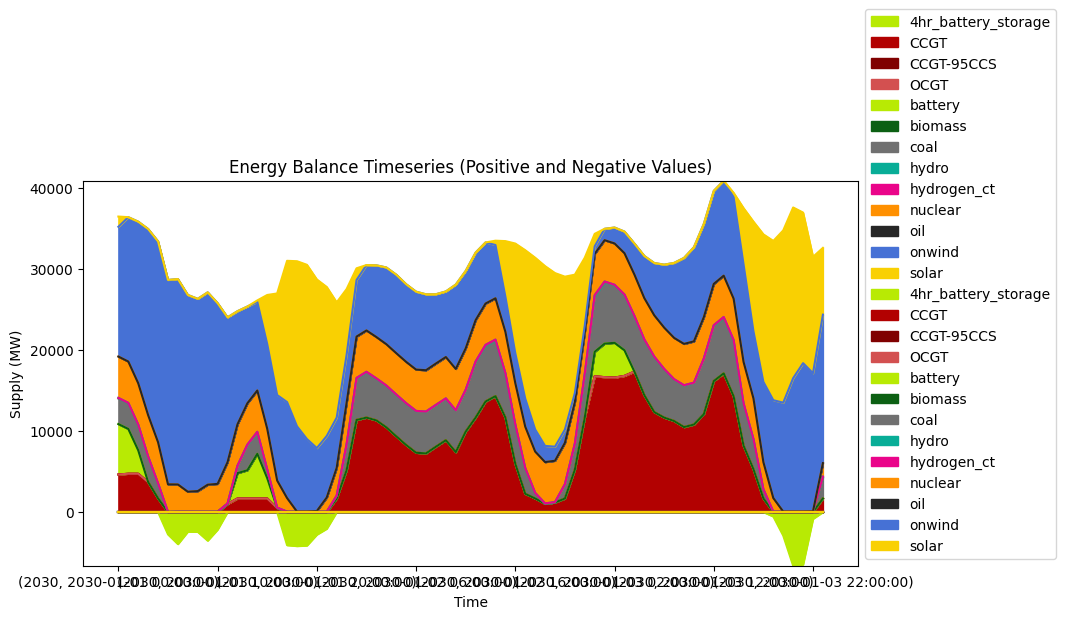

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Energy Balance Timeseries (Positive and Negative Values)'}, xlabel='Time', ylabel='Supply (MW)'>)

In [66]:
plot_energy_balance(clustered_network, 24 * 3)

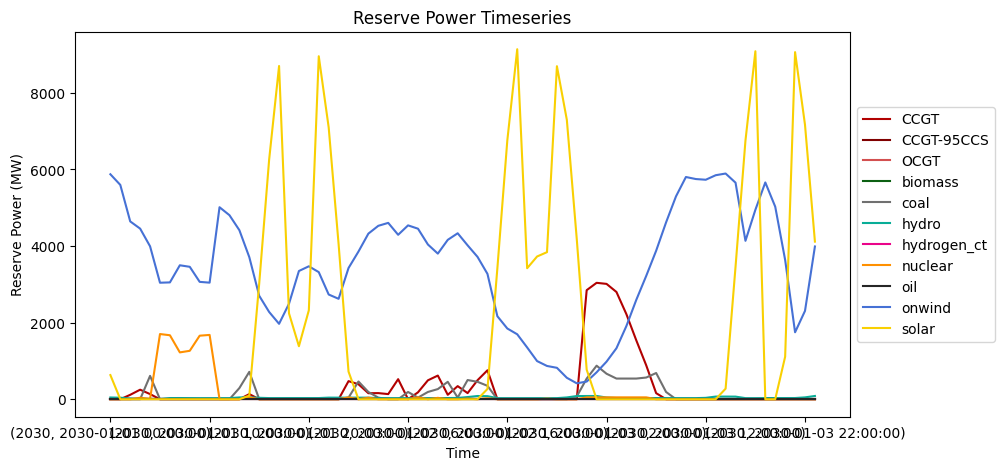

In [67]:
fig, ax = plt.subplots(figsize=(10, 5))
reserve_power = clustered_network.generators_t["p_reserve"].iloc[0:72].T
grouped_reserve_power = reserve_power.groupby(clustered_network.generators.carrier).sum().T

# Get colors for each carrier
colors = [clustered_network.carriers.loc[carrier, 'color'] for carrier in grouped_reserve_power.columns]

grouped_reserve_power.plot(ax=ax, color=colors)

ax.set_title("Reserve Power Timeseries")
ax.set_ylabel("Reserve Power (MW)")
ax.set_xlabel("Time")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


<Axes: xlabel='carrier'>

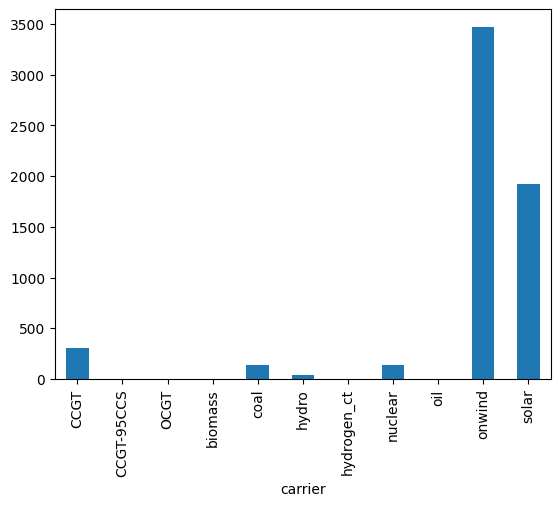

In [68]:
clustered_network.generators_t["p_reserve"].iloc[0:72].mean().groupby(clustered_network.generators.carrier).sum().plot(kind="bar")

In [69]:
clustered_network.generators_t["p_reserve"].iloc[0:72].sum(axis=1)

period  timestep           
2030    2030-01-01 00:00:00     6551.654334
        2030-01-01 01:00:00     5637.081971
        2030-01-01 02:00:00     4778.889952
        2030-01-01 03:00:00     4752.433215
        2030-01-01 04:00:00     4752.433215
                                   ...     
        2030-01-03 19:00:00     5059.335374
        2030-01-03 20:00:00     4778.816861
        2030-01-03 21:00:00    10845.458961
        2030-01-03 22:00:00     9523.850469
        2030-01-03 23:00:00     8190.391154
Length: 72, dtype: float64